# Classification Models: SVM, Random Forest, and Neural Network

This notebook trains **three supervised classification models** to predict **`RiskRating`** from an ASSI-A responses dataset.

## What this notebook does

- **Loads** a labeled CSV dataset (`ASSI-A-Responses Labeled.csv`).
- **Preprocesses** inputs (encodes `Gender`, encodes the target labels, and scales numeric features for models that benefit from it).
- **Trains**:
  - **SVM** (RBF kernel)
  - **Random Forest**
  - **Neural Network** (Keras)
- **Evaluates** each model on train/validation/test splits and prints:
  - Accuracy
  - Classification report (precision/recall/F1 per class)
  - Confusion matrix
- **Exports** preprocessing artifacts (scaler + encoders), and demonstrates saving/loading a neural network.

## Dataset expectations

This notebook assumes the CSV contains:

- **Identifiers**: `StudentNumber`
- **Features**: `Gender`, `GradeLevel`, `Q1` … `Q28`
- **Target**: `RiskRating` (string labels like `Low`, `Medium`, `High`)

## Important notes (read before interpreting metrics)

- **Class imbalance**: `Low` is much more frequent than `Medium`/`High`. Accuracy can look “good” while minority-class recall is poor.
- **Label encoders**: `LabelEncoder` assigns integer IDs in **alphabetical order** of class names. The notebook prints the mapping so you can verify it.
- **Scaling**: scaling is fit **only on the training set** to avoid leaking information from validation/test.


In [ ]:
# Import necessary libraries
#
# Notes:
# - Pandas/Numpy: tabular data manipulation
# - scikit-learn: classical ML models + preprocessing + metrics
# - TensorFlow/Keras: neural network model
# - warnings: keeps notebook output cleaner (optional)
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")


Libraries imported successfully!
TensorFlow version: 2.19.0


## 1. Load and Explore Data

In this section we:

- Load the labeled dataset from CSV.
- Sanity-check the dataset:
  - **Shape**: number of rows (students) × columns (features + target)
  - **Head**: a quick look at sample rows
  - **Dtypes**: confirms which columns are numeric vs categorical
  - **Missing values**: missing data can break training or introduce bias
  - **Target distribution**: reveals class imbalance (common for risk labels)


In [ ]:
# Load the dataset
#
# What happens here:
# - Read the labeled CSV into a Pandas DataFrame.
# - Print a few quick diagnostics so we know what we're training on.
#
# Why it matters:
# - Shape + dtypes confirm the feature set is what we expect.
# - Missing values can break preprocessing/training.
# - Target distribution highlights class imbalance (common for risk labels).

df = pd.read_csv('ASSI-A-Responses Labeled.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nColumn names: {df.columns.tolist()}")
print(f"\nData types:")
print(df.dtypes)
print(f"\nMissing values:")
print(df.isnull().sum().sum())
print(f"\nTarget variable distribution:")
print(df['RiskRating'].value_counts())


Dataset shape: (5377, 32)

First few rows:
   StudentNumber  Gender  GradeLevel  Q1  Q2  Q3  Q4  Q5  Q6  Q7  ...  Q20  \
0              1  Female           1   7   6   1   4   3   5   4  ...    6   
1              2  Female           1   3   7   4   6   2   7   6  ...    7   
2              3  Female           1   4   5   4   7   2   7   6  ...    7   
3              4    Male           1   4   4   4   6   1   5   2  ...    5   
4              5  Female           1   3   5   3   7   2   5   3  ...    5   

   Q21  Q22  Q23  Q24  Q25  Q26  Q27  Q28  RiskRating  
0    5    3    7    4    5    2    7    6         Low  
1    7    4    5    3    4    1    2    5         Low  
2    7    2    6    4    6    2    5    5         Low  
3    6    3    6    5    6    3    7    6         Low  
4    7    5    6    5    7    2    7    6         Low  

[5 rows x 32 columns]

Column names: ['StudentNumber', 'Gender', 'GradeLevel', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12

## 2. Data Preprocessing

Here we convert the raw DataFrame into:

- **`X`**: the model inputs (features)
- **`y`**: the model output (target label)

### Key preprocessing steps

- **Drop non-feature columns**: `StudentNumber` is an identifier and is not used to predict risk.
- **Encode categorical columns**:
  - `Gender` is converted into an integer (e.g., `Female -> 0`, `Male -> 1`).
- **Encode the target (`RiskRating`)**:
  - `RiskRating` is turned into integer class IDs (order is alphabetical by default for `LabelEncoder`).

### Why this matters

Most ML models require numeric arrays. Encoding also ensures that training and inference use the **same mapping**.


In [ ]:
# Prepare features and target
#
# Goal:
# - Build X (features) and y (target) in a form ML models can consume.
#
# Notes:
# - We drop StudentNumber because it's an identifier, not a predictive feature.
# - We use LabelEncoder for:
#   - Gender (categorical -> numeric)
#   - RiskRating (string labels -> integer class IDs)
#
# Important:
# - LabelEncoder assigns class IDs based on sorted label names.
#   Example: ['High', 'Low', 'Medium'] -> [0, 1, 2]

# Drop non-feature + target columns from X
X = df.drop(['StudentNumber', 'RiskRating'], axis=1)
y = df['RiskRating']

# Encode categorical variables (Gender)
label_encoder_gender = LabelEncoder()
X['Gender'] = label_encoder_gender.fit_transform(X['Gender'])

# Encode target variable
label_encoder_target = LabelEncoder()
y_encoded = label_encoder_target.fit_transform(y)

# Print shapes + mappings for verification
print(f"Features shape: {X.shape}")
print(f"Target shape: {y_encoded.shape}")
print(f"\nFeature columns: {X.columns.tolist()}")
print(f"\nTarget classes: {label_encoder_target.classes_}")
print(f"\nEncoded target distribution:")
unique, counts = np.unique(y_encoded, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  Class {u} ({label_encoder_target.classes_[u]}): {c} samples")


Features shape: (5377, 30)
Target shape: (5377,)

Feature columns: ['Gender', 'GradeLevel', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20', 'Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'Q27', 'Q28']

Target classes: ['High' 'Low' 'Medium']

Encoded target distribution:
  Class 0 (High): 113 samples
  Class 1 (Low): 4890 samples
  Class 2 (Medium): 374 samples


## 3. Train/Validation/Test Split

We split the dataset into three parts:

- **Train**: used to fit model parameters
- **Validation**: used to tune hyperparameters / compare model variants
- **Test**: used once at the end to estimate generalization performance

### Important note about the current split

The code below uses `test_size=0.4` for the first split, which results in **60% train** and **40% temp**.
That `temp` set is then split evenly into **20% validation** and **20% test**.

So the effective split is **60/20/20**, even though older notes often label this section as 80/10/10.


In [ ]:
# Train/Validation/Test split
#
# Why we split:
# - Train: fit the model
# - Val: tune hyperparameters / compare models
# - Test: final unbiased estimate
#
# Key details:
# - stratify=... keeps the class distribution similar across splits (important with imbalance).
# - random_state=42 makes the split reproducible.
#
# NOTE: With test_size=0.4, the first split yields 60% train and 40% temp.
#       The temp set is then split 50/50 -> 20% val and 20% test overall.

# First split: 60% train, 40% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded, test_size=0.4, random_state=42, stratify=y_encoded
)

# Second split: temp -> 50% val, 50% test (=> 20%/20% overall)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Print counts + percentages so you can confirm the split
print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nTotal samples: {X_train.shape[0] + X_val.shape[0] + X_test.shape[0]}")


Training set: 3226 samples (60.0%)
Validation set: 1075 samples (20.0%)
Test set: 1076 samples (20.0%)

Total samples: 5377


In [ ]:
# Feature scaling (Standardization)
#
# What is happening:
# - We fit a StandardScaler on the training set and transform train/val/test.
# - StandardScaler converts each feature to roughly mean=0 and std=1.
#
# Why it matters:
# - SVMs and Neural Networks often benefit from feature scaling.
# - IMPORTANT: we fit ONLY on the training set to avoid data leakage.

scaler = StandardScaler()

# Fit on training data
X_train_scaled = scaler.fit_transform(X_train)

# Use the same fitted scaler for validation/test
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Features scaled successfully!")
print(f"Scaled training set shape: {X_train_scaled.shape}")


Features scaled successfully!
Scaled training set shape: (3226, 30)


## 4. Model 1: Support Vector Machine (SVM)

### What we’re training

An **SVM classifier** with an RBF kernel (`kernel='rbf'`).

### Why scaling is required

SVMs are sensitive to the scale of features. That’s why we use the **scaled** arrays (`X_*_scaled`).

### Output

We generate predictions for train/validation/test, then evaluate with accuracy, classification report, and confusion matrix.


In [ ]:
# Train SVM model
#
# What is happening:
# - Create an SVC (Support Vector Classifier) with:
#   - RBF kernel: non-linear decision boundary
#   - probability=True: enables predict_proba (slower, but useful for downstream scoring)
#   - random_state: reproducibility (affects internal probability calibration)
# - Fit using scaled training features.
# - Generate predictions for each split.

print("Training SVM model...")
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)

# Predictions (class IDs)
y_train_pred_svm = svm_model.predict(X_train_scaled)
y_val_pred_svm = svm_model.predict(X_val_scaled)
y_test_pred_svm = svm_model.predict(X_test_scaled)

print("SVM model trained successfully!")


Training SVM model...
SVM model trained successfully!


In [ ]:
# SVM Evaluation Report
#
# What we print:
# - Accuracy: overall fraction correct (can be misleading with imbalanced classes).
# - Classification report: precision/recall/F1 per class.
# - Confusion matrix: counts of predicted vs actual classes.
#
# Note:
# - We pass target_names=label_encoder_target.classes_ so metrics are labeled with the original
#   RiskRating strings (High/Low/Medium) instead of integer IDs.

print("=" * 60)
print("SVM MODEL EVALUATION REPORT")
print("=" * 60)

print("\n--- Training Set Performance ---")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred_svm):.4f}")
print("\nClassification Report:")
print(classification_report(
    y_train,
    y_train_pred_svm,
    target_names=label_encoder_target.classes_,
))
print("\nConfusion Matrix:")
print(confusion_matrix(y_train, y_train_pred_svm))

print("\n--- Validation Set Performance ---")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred_svm):.4f}")
print("\nClassification Report:")
print(classification_report(
    y_val,
    y_val_pred_svm,
    target_names=label_encoder_target.classes_,
))
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_svm))

print("\n--- Test Set Performance ---")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred_svm):.4f}")
print("\nClassification Report:")
print(classification_report(
    y_test,
    y_test_pred_svm,
    target_names=label_encoder_target.classes_,
))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_svm))
print("=" * 60)


SVM MODEL EVALUATION REPORT

--- Training Set Performance ---
Accuracy: 0.9740

Classification Report:
              precision    recall  f1-score   support

        High       1.00      0.59      0.74        68
         Low       0.98      1.00      0.99      2934
      Medium       0.86      0.77      0.81       224

    accuracy                           0.97      3226
   macro avg       0.95      0.78      0.85      3226
weighted avg       0.97      0.97      0.97      3226


Confusion Matrix:
[[  40    3   25]
 [   0 2930    4]
 [   0   52  172]]

--- Validation Set Performance ---
Accuracy: 0.9284

Classification Report:
              precision    recall  f1-score   support

        High       0.00      0.00      0.00        22
         Low       0.95      0.99      0.97       978
      Medium       0.56      0.40      0.47        75

    accuracy                           0.93      1075
   macro avg       0.50      0.46      0.48      1075
weighted avg       0.90      0.93      

## 5. Model 2: Random Forest

### What we’re training

A **RandomForestClassifier** (an ensemble of decision trees).

### Why scaling is not required

Tree-based models are generally **scale-invariant**, so we train the Random Forest on the **unscaled** feature matrices (`X_train`, `X_val`, `X_test`).

### Output

We predict on train/validation/test and print the same evaluation metrics as the SVM.


In [ ]:
# Train Random Forest model
#
# What is happening:
# - Train a RandomForestClassifier (many decision trees + bagging).
# - n_estimators=100: number of trees in the forest.
# - n_jobs=-1: use all available CPU cores.
# - Fit uses UN-SCALED features (tree models don't require scaling).
# - Generate predictions for train/val/test.

print("Training Random Forest model...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Predictions (class IDs)
y_train_pred_rf = rf_model.predict(X_train)
y_val_pred_rf = rf_model.predict(X_val)
y_test_pred_rf = rf_model.predict(X_test)

print("Random Forest model trained successfully!")


Training Random Forest model...
Random Forest model trained successfully!


In [ ]:
# Random Forest Evaluation Report
#
# Same evaluation approach as SVM:
# - Accuracy
# - Per-class precision/recall/F1
# - Confusion matrix
#
# Reminder:
# - With strong class imbalance, focus on minority-class recall/F1 (e.g., `High`, `Medium`).

print("=" * 60)
print("RANDOM FOREST MODEL EVALUATION REPORT")
print("=" * 60)

print("\n--- Training Set Performance ---")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred_rf):.4f}")
print("\nClassification Report:")
print(classification_report(
    y_train,
    y_train_pred_rf,
    target_names=label_encoder_target.classes_,
))
print("\nConfusion Matrix:")
print(confusion_matrix(y_train, y_train_pred_rf))

print("\n--- Validation Set Performance ---")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred_rf):.4f}")
print("\nClassification Report:")
print(classification_report(
    y_val,
    y_val_pred_rf,
    target_names=label_encoder_target.classes_,
))
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_rf))

print("\n--- Test Set Performance ---")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred_rf):.4f}")
print("\nClassification Report:")
print(classification_report(
    y_test,
    y_test_pred_rf,
    target_names=label_encoder_target.classes_,
))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_rf))
print("=" * 60)


RANDOM FOREST MODEL EVALUATION REPORT

--- Training Set Performance ---
Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

        High       1.00      1.00      1.00        68
         Low       1.00      1.00      1.00      2934
      Medium       1.00      1.00      1.00       224

    accuracy                           1.00      3226
   macro avg       1.00      1.00      1.00      3226
weighted avg       1.00      1.00      1.00      3226


Confusion Matrix:
[[  68    0    0]
 [   0 2934    0]
 [   0    0  224]]

--- Validation Set Performance ---
Accuracy: 0.9163

Classification Report:
              precision    recall  f1-score   support

        High       0.00      0.00      0.00        22
         Low       0.92      1.00      0.96       978
      Medium       0.53      0.12      0.20        75

    accuracy                           0.92      1075
   macro avg       0.48      0.37      0.38      1075
weighted avg       0.88      

In [ ]:
# Feature importance for Random Forest
#
# What is happening:
# - Random Forest exposes feature_importances_ (rough measure of how much each feature reduces
#   impurity across the trees).
#
# Notes / caveats:
# - These importances are not causal and can be biased toward high-cardinality / high-variance features.
# - Still useful for a quick sanity-check of which questions (Q*) and demographics matter most.

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features (Random Forest):")
print(feature_importance.head(10))


Top 10 Most Important Features (Random Forest):
       feature  importance
13         Q12    0.086316
27         Q26    0.080896
1   GradeLevel    0.075160
6           Q5    0.071203
20         Q19    0.064696
7           Q6    0.031122
12         Q11    0.028931
10          Q9    0.028502
19         Q18    0.028476
26         Q25    0.028455


## 6. Model 3: Neural Network (TensorFlow/Keras)

### What we’re training

A small **feed-forward neural network** (multi-layer perceptron) using Keras.

### Key differences vs SVM/RF

- Uses **scaled features** (`X_*_scaled`).
- Uses **one-hot encoded labels** for training with `categorical_crossentropy`.
- Training is iterative (epochs/batches), and we can visualize learning curves.


In [ ]:
# Neural Network setup: determine shapes + one-hot encode labels
#
# What is happening:
# - n_classes: number of unique class IDs in y_train (e.g., 3 for High/Low/Medium)
# - n_features: number of input features (columns)
# - to_categorical: converts integer class IDs into one-hot vectors.
#   Example: class 1 in a 3-class problem -> [0, 1, 0]

n_classes = len(np.unique(y_train))
n_features = X_train_scaled.shape[1]

print(f"Number of features: {n_features}")
print(f"Number of classes: {n_classes}")

# Convert labels to categorical for neural network training
y_train_categorical = keras.utils.to_categorical(y_train, n_classes)
y_val_categorical = keras.utils.to_categorical(y_val, n_classes)
y_test_categorical = keras.utils.to_categorical(y_test, n_classes)

print(f"Training labels shape: {y_train_categorical.shape}")


Number of features: 30
Number of classes: 3
Training labels shape: (3226, 3)


In [ ]:
# Build Neural Network model
#
# Architecture overview:
# - Input: n_features numeric inputs
# - Hidden layers:
#   - Dense(64, relu)
#   - Dropout(0.3) to reduce overfitting
#   - Dense(32, relu)
#   - Dropout(0.2)
# - Output:
#   - Dense(n_classes, softmax) -> probability distribution over classes
#
# Compile settings:
# - optimizer='adam': common default optimizer
# - loss='categorical_crossentropy': standard loss for multi-class one-hot labels
# - metrics=['accuracy']: tracks accuracy during training

nn_model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(n_features,)),
    # You can experiment with architecture depth/width and dropout rates.
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(n_classes, activation='softmax'),
])

# Compile the model
nn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

# Display model architecture
print("Neural Network Architecture:")
nn_model.summary()


Neural Network Architecture:


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_23 (Dense)                │ (None, 64)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,163 (16.26 KB)

 Trainable params: 4,163 (16.26 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the Neural Network
#
# What is happening:
# - We train for a fixed number of epochs.
# - validation_data is used to compute validation metrics each epoch.
# - history captures metrics over time (used later for plots).
#
# Key hyperparameters:
# - epochs: number of full passes over the training set
# - batch_size: number of samples per gradient update

print("Training Neural Network model...")
history = nn_model.fit(
    X_train_scaled,
    y_train_categorical,
    validation_data=(X_val_scaled, y_val_categorical),
    epochs=10,
    batch_size=32,
    verbose=1,
)

print("\nNeural Network model trained successfully!")


Training Neural Network model...
Epoch 1/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8210 - loss: 0.5717 - val_accuracy: 0.9144 - val_loss: 0.2479
Epoch 2/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9112 - loss: 0.2686 - val_accuracy: 0.9172 - val_loss: 0.2151
Epoch 3/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9118 - loss: 0.2339 - val_accuracy: 0.9191 - val_loss: 0.2014
Epoch 4/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9208 - loss: 0.2019 - val_accuracy: 0.9200 - val_loss: 0.1917
Epoch 5/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9071 - loss: 0.2111 - val_accuracy: 0.9274 - val_loss: 0.1844
Epoch 6/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9242 - loss: 0.1759 - val_accuracy: 0.9256 - val_loss: 0.1790
Epoch 7/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9179 - loss: 0.1834 - val_accuracy: 0.9256 - val_loss: 0.1852
Epoch 8/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9343 

In [ ]:
# Neural Network Predictions
#
# What is happening:
# - predict(...) returns a probability distribution across classes (softmax output).
# - argmax(...) converts probabilities into a single class ID per sample.
#
# Example:
# - proba = [0.05, 0.90, 0.05] -> predicted class = 1

y_train_pred_nn_proba = nn_model.predict(X_train_scaled)
y_train_pred_nn = np.argmax(y_train_pred_nn_proba, axis=1)

y_val_pred_nn_proba = nn_model.predict(X_val_scaled)
y_val_pred_nn = np.argmax(y_val_pred_nn_proba, axis=1)

y_test_pred_nn_proba = nn_model.predict(X_test_scaled)
y_test_pred_nn = np.argmax(y_test_pred_nn_proba, axis=1)

print("Neural Network predictions generated!")


101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Neural Network predictions generated!


In [ ]:
# Neural Network Evaluation Report
#
# Same evaluation approach as other models.
# For imbalanced classes, check per-class recall and confusion matrix carefully.

print("=" * 60)
print("NEURAL NETWORK MODEL EVALUATION REPORT")
print("=" * 60)

print("\n--- Training Set Performance ---")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred_nn):.4f}")
print("\nClassification Report:")
print(classification_report(
    y_train,
    y_train_pred_nn,
    target_names=label_encoder_target.classes_,
))
print("\nConfusion Matrix:")
print(confusion_matrix(y_train, y_train_pred_nn))

print("\n--- Validation Set Performance ---")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred_nn):.4f}")
print("\nClassification Report:")
print(classification_report(
    y_val,
    y_val_pred_nn,
    target_names=label_encoder_target.classes_,
))
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_nn))

print("\n--- Test Set Performance ---")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred_nn):.4f}")
print("\nClassification Report:")
print(classification_report(
    y_test,
    y_test_pred_nn,
    target_names=label_encoder_target.classes_,
))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_nn))
print("=" * 60)


NEURAL NETWORK MODEL EVALUATION REPORT

--- Training Set Performance ---
Accuracy: 0.9423

Classification Report:
              precision    recall  f1-score   support

        High       0.75      0.04      0.08        68
         Low       0.97      0.99      0.98      2934
      Medium       0.61      0.56      0.58       224

    accuracy                           0.94      3226
   macro avg       0.77      0.53      0.55      3226
weighted avg       0.94      0.94      0.93      3226


Confusion Matrix:
[[   3    6   59]
 [   0 2912   22]
 [   1   98  125]]

--- Validation Set Performance ---
Accuracy: 0.9302

Classification Report:
              precision    recall  f1-score   support

        High       0.00      0.00      0.00        22
         Low       0.95      0.99      0.97       978
      Medium       0.57      0.39      0.46        75

    accuracy                           0.93      1075
   macro avg       0.51      0.46      0.48      1075
weighted avg       0.90     

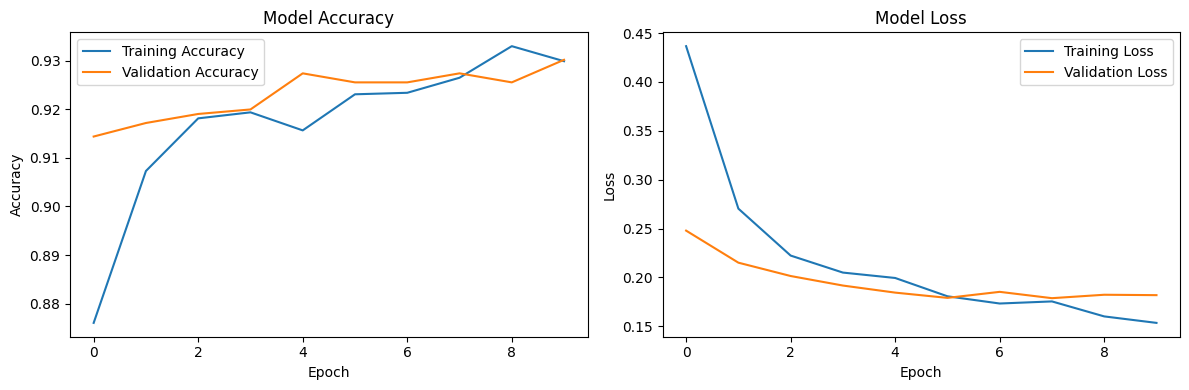

In [ ]:
# Plot training history for Neural Network
#
# What this plot shows:
# - Accuracy over epochs (train vs validation)
# - Loss over epochs (train vs validation)
#
# How to interpret:
# - If training accuracy increases while validation accuracy stalls/drops, you may be overfitting.
# - If both are low, you may be underfitting (model too small / not enough epochs / features).

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Accuracy curves
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss curves
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## 7. Model Comparison Summary

In this final section we compare the models on the **test set**.

### Why compare on the test set?

- The test set is meant to represent “new/unseen” data.
- We only look at it after model development decisions are mostly done.

### Important caveat

Because the dataset is imbalanced, you should compare:

- **Overall accuracy** (quick but can be misleading)
- **Per-class metrics** (especially recall for `High` risk)
- **Confusion matrices** (what errors are being made)


In [ ]:
# Compare all models on the test set
#
# What is happening:
# - We collect each model's test predictions.
# - We compute test accuracy for each.
# - We print a small table and select the best by accuracy.
#
# Note:
# - "Best" here means highest accuracy. With class imbalance, consider also comparing
#   macro-F1 or per-class recall (especially for the High-risk class).

print("=" * 60)
print("MODEL COMPARISON - TEST SET PERFORMANCE")
print("=" * 60)

models = {
    'SVM': y_test_pred_svm,
    'Random Forest': y_test_pred_rf,
    'Neural Network': y_test_pred_nn,
}

comparison_df = pd.DataFrame({
    'Model': list(models.keys()),
    'Test Accuracy': [accuracy_score(y_test, pred) for pred in models.values()],
})

print("\nTest Set Accuracy Comparison:")
print(comparison_df.to_string(index=False))

print("\n" + "=" * 60)
print("Best Model:", comparison_df.loc[comparison_df['Test Accuracy'].idxmax(), 'Model'])
print("Best Accuracy:", f"{comparison_df['Test Accuracy'].max():.4f}")
print("=" * 60)


MODEL COMPARISON - TEST SET PERFORMANCE

Test Set Accuracy Comparison:
         Model  Test Accuracy
           SVM       0.924721
 Random Forest       0.912639
Neural Network       0.917286

Best Model: SVM
Best Accuracy: 0.9247


In [ ]:
# Save the trained Neural Network model to disk
#
# Notes:
# - This uses the legacy HDF5 format (.h5).
# - Newer Keras versions recommend the native format: model.save('my_model.keras')
# - We keep .h5 here to match the rest of the notebook example.

nn_model.save('nn_model.h5')


In [ ]:
# Load the saved Neural Network model from disk
#
# Notes:
# - This demonstrates persistence: you can train once and load later for inference.
# - You may see a warning about compiled metrics not being built until you evaluate/train.

loaded_nn_model = tf.keras.models.load_model('nn_model.h5')
print("Neural Network model loaded successfully!")


Neural Network model loaded successfully!


In [ ]:
# Inference demo: run the saved model on (new) data
#
# What this cell demonstrates:
# - How to take a new CSV, apply the SAME preprocessing (encoders + scaler),
#   and produce predicted RiskRating labels.
#
# IMPORTANT:
# - In a real deployment, your new data usually will NOT include the true RiskRating.
# - Here we re-load the same labeled dataset just to show end-to-end prediction.

# Load new data (replace this with your real, unlabeled ASSI-A responses CSV)
new_df = pd.read_csv('ASSI-A-Responses Labeled.csv')

print(f"New data shape: {new_df.shape}")
print(f"\nFirst 5 rows of new data:\n{new_df.head()}")

# Preprocess the new data using the same steps as the training data
# - Drop identifier/target columns if present
X_new = new_df.drop(['StudentNumber', 'RiskRating'], axis=1, errors='ignore')

# Encode categorical variables using the fitted encoders
X_new['Gender'] = label_encoder_gender.transform(X_new['Gender'])

# Scale features using the fitted scaler (fit was done on train only)
X_new_scaled = scaler.transform(X_new)

print(f"\nProcessed new data shape: {X_new_scaled.shape}")

# Make predictions using the loaded Neural Network model
# - Output is probabilities, then we pick the most likely class (argmax)
new_predictions_proba = loaded_nn_model.predict(X_new_scaled)
new_predictions_encoded = np.argmax(new_predictions_proba, axis=1)

# Convert integer class IDs back to human-readable RiskRating labels
new_predictions_labels = label_encoder_target.inverse_transform(new_predictions_encoded)

# Display some predictions
print("\nPredictions for the first 10 new data samples:")
for i in range(10):
    print(f"Sample {i+1}: Predicted RiskRating = {new_predictions_labels[i]}")

# Optionally, attach predictions back onto the DataFrame
new_df['Predicted_RiskRating'] = new_predictions_labels
print("\nNew data with predictions (first 5 rows):")
print(new_df[['StudentNumber', 'Gender', 'GradeLevel', 'RiskRating', 'Predicted_RiskRating']].head())


New data shape: (5377, 32)

First 5 rows of new data:
   StudentNumber  Gender  GradeLevel  Q1  Q2  Q3  Q4  Q5  Q6  Q7  ...  Q20  \
0              1  Female           1   7   6   1   4   3   5   4  ...    6   
1              2  Female           1   3   7   4   6   2   7   6  ...    7   
2              3  Female           1   4   5   4   7   2   7   6  ...    7   
3              4    Male           1   4   4   4   6   1   5   2  ...    5   
4              5  Female           1   3   5   3   7   2   5   3  ...    5   

   Q21  Q22  Q23  Q24  Q25  Q26  Q27  Q28  RiskRating  
0    5    3    7    4    5    2    7    6         Low  
1    7    4    5    3    4    1    2    5         Low  
2    7    2    6    4    6    2    5    5         Low  
3    6    3    6    5    6    3    7    6         Low  
4    7    5    6    5    7    2    7    6         Low  

[5 rows x 32 columns]

Processed new data shape: (5377, 30)
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Predictions for the first 10 new data 

In [ ]:
# Inspect class imbalance
#
# Why it matters:
# - If one class dominates (e.g., many "Low" ratings), accuracy can be high even if the model
#   performs poorly on minority classes ("High" risk is usually the most important).

print("Class counts in the original dataset:")
print(df['RiskRating'].value_counts())


Class counts in the original dataset:
RiskRating
Low       4890
Medium     374
High       113
Name: count, dtype: int64


In [ ]:
# Export preprocessing artifacts (scaler + label encoders)
#
# Why this matters:
# - Your model expects inputs to be transformed EXACTLY the same way during inference.
# - Saving these objects allows you to reproduce preprocessing in an API / pipeline.
#
# Files saved:
# - scaler.pkl: StandardScaler fitted on X_train
# - label_encoder_gender.pkl: LabelEncoder fitted on Gender
# - label_encoder_target.pkl: LabelEncoder fitted on RiskRating

import joblib

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')
print("Scaler saved to 'scaler.pkl'")

# Save the gender label encoder
joblib.dump(label_encoder_gender, 'label_encoder_gender.pkl')
print("Gender LabelEncoder saved to 'label_encoder_gender.pkl'")

# Save the target label encoder
joblib.dump(label_encoder_target, 'label_encoder_target.pkl')
print("Target LabelEncoder saved to 'label_encoder_target.pkl'")

print("All preprocessing transformers exported successfully!")

Scaler saved to 'scaler.pkl'
Gender LabelEncoder saved to 'label_encoder_gender.pkl'
Target LabelEncoder saved to 'label_encoder_target.pkl'
All preprocessing transformers exported successfully!
